In [24]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from os import listdir
from PIL import Image
from collections import defaultdict

from IPython.display import display, clear_output

# Data loading

In [27]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

In [3]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [4]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [5]:
def get_dataloader(bs=256, train_fr=.6, max_images_per_class=1e9):
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()

            # gather the images with labels
            i = 0
            for img_id in img_ids:
                img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                img = Image.open(img_path)

                # some images are black-and-white so convert to rgb
                img_rgb = img.convert('RGB')
                img_data = np.asarray(img_rgb)
                
                img_data = img_data.flatten()
                img_to_data[img_id] = img_data

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class:
                    break

                i += 1

    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_class.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])
        
    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    train_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float),
        torch.tensor(y_train, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)           

    valid_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_valid, dtype=torch.float),
        torch.tensor(y_valid, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)

    test_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_test, dtype=torch.float),
        torch.tensor(y_test, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)      

    return train_dataloader, valid_dataloader, test_dataloader

# Batch statistics

In [75]:
def avg_batch_statistics(dataloader):
    
    means = []
    stds = []
    
    for idx, (batch, _) in enumerate(dataloader):
        batch = batch.numpy().reshape(-1, 3, 128, 128)
        means.append(np.average(batch, axis=(0,2,3)))
        stds.append(np.std(batch, axis=(0,2,3), ddof=1))    
        
    return np.array(means).mean(axis=0), np.array(stds).mean(axis=0)

def running_batch_statistics(dataloader, momentum=.5):

    mean = 0
    var_ = 0
    
    for idx, (batch, _) in enumerate(dataloader):
        batch = batch.numpy().reshape(-1, 3, 128, 128)
        b_mean, b_var = np.average(batch, axis=(0,2,3)), np.var(batch, axis=(0,2,3))
        mean = momentum * mean + (1 - momentum) * b_mean
        var_ = momentum * var_ + (1 - momentum) * b_var

    return mean, np.sqrt(var_) # We need not divide by 255
    

fmt = lambda arr: ", ".join(["%.8f" % x for x in arr])

if True:
    
    images_root = '../data/images2'
    
    # NB: RuntimeError: Found 0 files in subfolders of: ../data/images
    # => Put images in any arbitrary subfolder structure like '../data/images/0'
    dataset = ImageFolder(root=images_root, transform=transforms.Compose([ transforms.ToTensor() ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs)
    
    mean, var_ = avg_batch_statistics(dataloader)
    print(f'\nAverage batch statistic:\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    mean, var_ = running_batch_statistics(dataloader)
    print(f'\nRunning batch statistic:\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    
if False:

    from torchvision.datasets import CIFAR10
    
    images_root = '../data/CIFAR10'
    
    print('\nTrainset:')
    
    dataset = torchvision.datasets.CIFAR10(root=f'{images_root}/train/', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs)

    mean, var_ = avg_batch_statistics(dataloader)
    print(f'\nAverage batch statistic:\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    mean, var_ = running_batch_statistics(dataloader)
    print(f'\nRunning batch statistic:\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    print('\nDevset:')
    
    dataset = torchvision.datasets.CIFAR10(root=f'{images_root}/test/', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs)
    
    mean, var_ = avg_batch_statistics(dataloader)
    print(f'\nAverage batch statistic:\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    mean, var_ = running_batch_statistics(dataloader)
    print(f'\nRunning batch statistic:\nMEAN=({fmt(mean)}), STD=({fmt(var_)})')
    
    #
    # Correct normalization values for CIFAR-10: 
    # (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
    #
    # https://github.com/kuangliu/pytorch-cifar/issues/19
    #

Files already downloaded and verified

Trainset:

Average batch statistic:
MEAN=(0.47369438, 0.47294450, 0.47349018), STD=(0.25084943, 0.25098413, 0.25254464)

Running batch statistic:
MEAN=(0.47834221, 0.47608432, 0.47120976), STD=(0.24923639, 0.25167778, 0.25235027)

Devset:


100.0%

Extracting ../data/CIFAR10/test/cifar-10-python.tar.gz to ../data/CIFAR10/test/

Average batch statistic:
MEAN=(0.47803268, 0.47714883, 0.47439894), STD=(0.25221434, 0.24955742, 0.25180250)

Running batch statistic:
MEAN=(0.47648752, 0.47191909, 0.47236240), STD=(0.25622901, 0.24950832, 0.25218105)


# Models

In [6]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [7]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

# Training and evaluation functions

In [8]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y_pred.cpu() > threshold, y.cpu() == 1, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [9]:
def train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=50, verbose=True):
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))

In [10]:
def visualize_predictions(model, device, dataloader, n_to_show=3, threshold=0.5):
    class_to_label = { v: k for k, v in get_class_map().items() }

    for i, batch in enumerate(dataloader):
        n_shown = 0
        
        X, y = batch
        X = X.to(device)

        y_pred = model(X) > threshold
        y = y == 1

        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]

            true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
            pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

            img = X[i].cpu().numpy().reshape((128, 128, 3)).astype(np.uint8)
            plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
            plt.imshow(img)
            plt.pause(0.001)

            if n_shown >= n_to_show:
                return

            n_shown += 1
            
    print("Done")
            

# Do the magic!

In [11]:
use_cuda = False

device = torch.device('cuda') if use_cuda else torch.device('cpu')

lr = 0.01
n_epochs = 2 #10
bs = 64 #256

n_classes = len(get_class_map().keys())

model = TwoLayerModel(128*128*3, 512, 256, n_classes).to(device)
#model = OneLayerModel(128*128*3, 128, n_classes).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Create and save / load dataloaders from disk

In [14]:
try:
    train_dataloader = torch.load('../data/train_dataloader.dat')
    valid_dataloader = torch.load('../data/valid_dataloader.dat')
    test_dataloader = torch.load('../data/test_dataloader.dat')
except:
    train_dataloader, valid_dataloader, test_dataloader = get_dataloader(bs=bs)
    torch.save(train_dataloader, '../data/train_dataloader.dat')
    torch.save(valid_dataloader, '../data/valid_dataloader.dat')
    torch.save(test_dataloader, '../data/test_dataloader.dat')
    print('Done')

Reading class: tree
Reading class: female
Reading class: flower
Reading class: dog
Reading class: sea
Reading class: people
Reading class: portrait
Reading class: car
Reading class: clouds
Reading class: male
Reading class: river
Reading class: bird
Reading class: night
Reading class: baby


## Do the actual training

In [15]:
train(train_dataloader, valid_dataloader, model, optimizer, criterion, device, n_epochs=n_epochs)

Epoch Train loss   Valid loss   Train F1  Valid F1 
0     0.5493558645 0.5660586953 0.3839785 0.3119794
1     0.4080949128 0.4381308556 0.4820955 0.3684563
2     0.2933428586 0.3406626880 0.5050472 0.3641808


KeyboardInterrupt: 

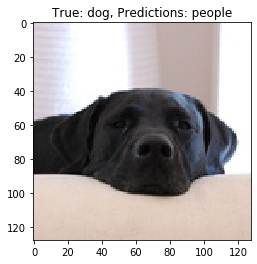

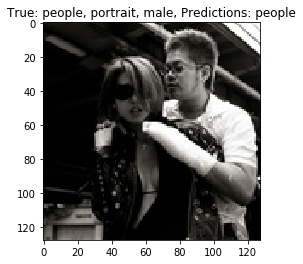

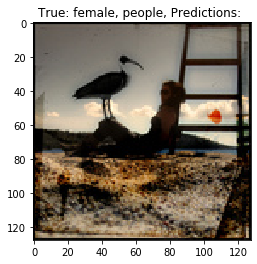

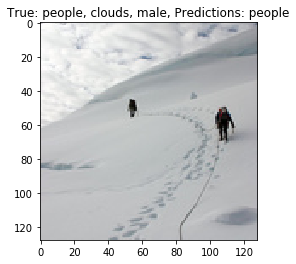

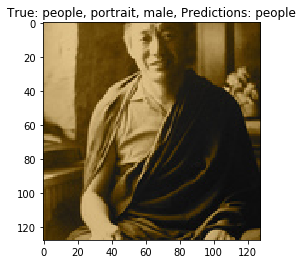

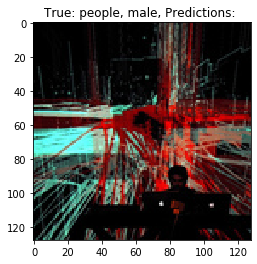

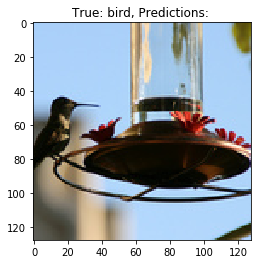

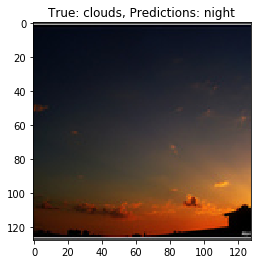

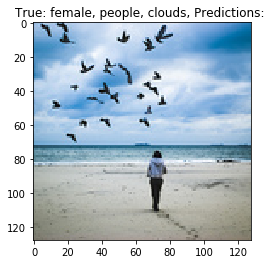

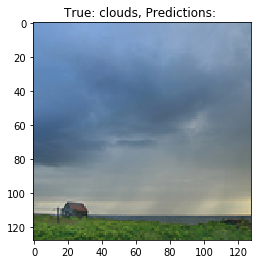

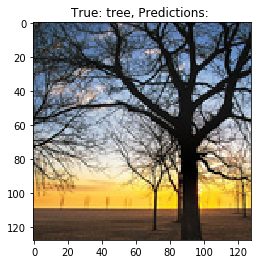

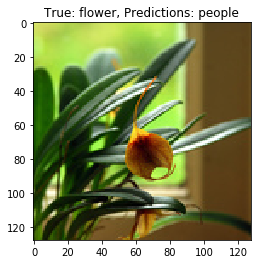

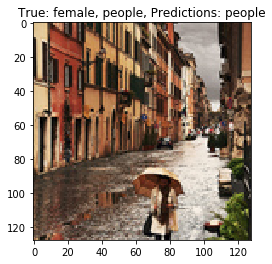

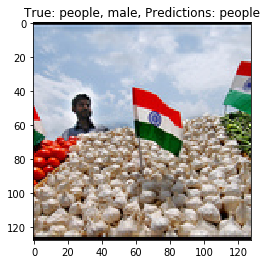

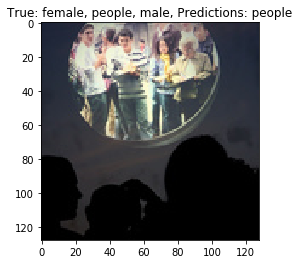

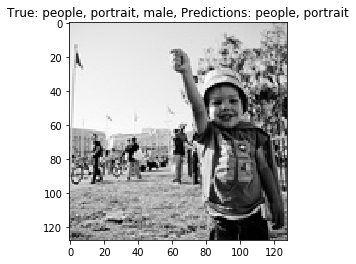

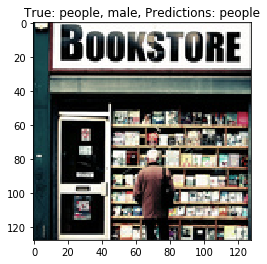

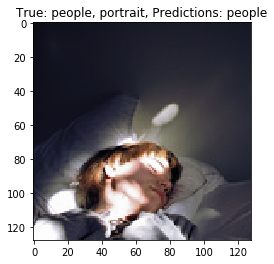

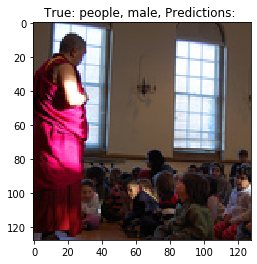

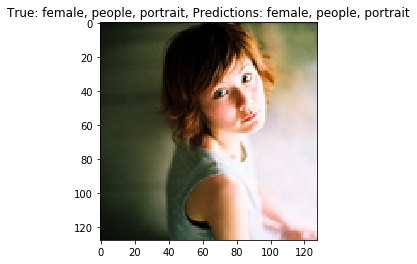

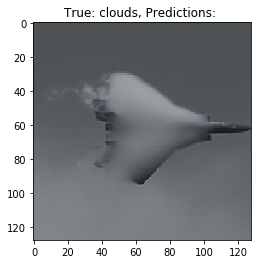

In [16]:
visualize_predictions(model, device, valid_dataloader, n_to_show=20)